In [1]:
import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt
from pathlib import Path
import pprint
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from dataset import *

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [3]:
output_dir = '.'
boc =  BrainObservatoryCache(
    manifest_file=str(Path(output_dir) / 'brain_observatory_manifest.json'))
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


In [4]:
# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)
cre_lines_to_use = [
    'Cux2-CreERT2',
    'Emx1-IRES-Cre',
    'Fezf2-CreER',
    'Nr5a1-Cre',
    'Ntsr1-Cre_GN220',
    'Rbp4-Cre_KL100',
    'Rorb-IRES2-Cre',
    'Scnn1a-Tg3-Cre',
    'Slc17a7-IRES2-Cre',
    'Tlx3-Cre_PL56',
]

all cre lines:

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


Download Experiments for a Container

An experiment container is a group of experiments. Each experiment has a different stimulus protocol. For example, one experiment protocol contains the static gratings stimulus and another has the natural scenes stimulus. The BrainObservatoryCache helps you find out which experiment associated with a container has the stimuli you are interested in. First, let's see what experiments are available for a single container.

The session_type field indicates which experimental protocol was used. If you just want to find which experiment contains the static gratings stimulus, you can do the following:

In [7]:
# import allensdk.brain_observatory.stimulus_info as stim_info

# # pick one of the cux2 experiment containers
# cux2_ec_id = cux2_ecs[-1]['id']

# # Find the experiment with the static static gratings stimulus
# exp = boc.get_ophys_experiments(experiment_container_ids=[cux2_ec_id], 
#                                 stimuli=[stim_info.STATIC_GRATINGS])[0]
# print("Experiment with static gratings:")
# pprint.pprint(exp)

Now we can download the NWB file for this experiment.

In [5]:
exps = get_exps(boc, cre_lines=cre_lines_to_use, targeted_structures=None, session_types=['three_session_B'])

In [6]:
cells = boc.get_cell_specimens() # initiate cells object. it includes properties of all neurons recorded, including orientation selectivity, etc.
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

total cells: 63251


In [10]:
# # for downloading all defined experiment sessions
# cellnum = []
# for exp in exps:
#     data_set = boc.get_ophys_experiment_data(exp['id'])
#     cellnum.append(len(data_set.get_cell_specimen_ids()))

# # print out the metadata available in the NWB file
# #pprint.pprint(data_set.get_metadata())
# cells = boc.get_cell_specimens() # initiate cells object. it includes properties of all neurons recorded, including orientation selectivity, etc.
# cells = pd.DataFrame.from_records(cells)
# print("total cells: %d" % len(cells))

In [7]:
session_data = boc.get_ophys_experiment_data(exps[22]['id'])
session_metadata = session_data.get_metadata()
print(len(session_data.get_cell_specimen_ids()))

120


In [8]:
dFF = get_fluo(boc, exps[22])
dFF.shape

(120, 113873)

In [ ]:
ax_dFF = plot_traces(dFF,np.arange(0,3000), 'Neuron', figsize = [10,10])

In [9]:
session_stim = get_stim_df(boc, exps[22], stimulus_name='natural_scenes')
session_stim

,frame,start,end
0,26,16103,16110
1,32,16110,16117
2,10,16118,16125
3,63,16125,16132
4,20,16133,16140
...,...,...,...
5945,103,96073,96080
5946,81,96081,96088
5947,36,96088,96095
5948,9,96096,96103


In [28]:
len(set(session_stim['frame'].to_numpy()))

119

In [10]:
pca_dff, recon_dff = pca_and_pad(dFF)

In [12]:
prefix_frame = 30
natural_scene_data, labels = extract_data_by_images(pca_dff, session_stim, pre=prefix_frame, post=7)
natural_scene_data[0].shape

(50, 45)

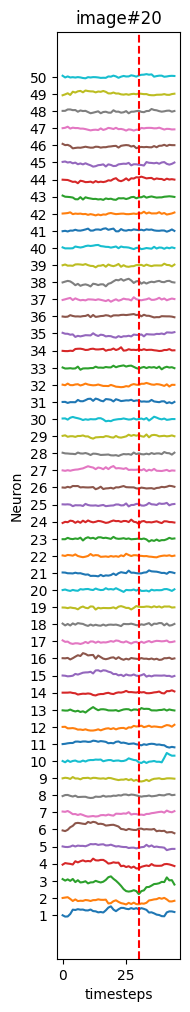

In [17]:
id = 4
ax = plot_traces(natural_scene_data[id],np.arange(0,natural_scene_data[id].shape[1]), 'Neuron', figsize=(2,10))
ax.set_title(f'image#{labels[id]}')
ax.axvline(x = prefix_frame, color = 'r', linestyle = '--')

In [ ]:

ax1 = plot_traces(pca_dff, np.arange(0,3000), input_type='pca')
ax2 = plot_traces(recon_dff, np.arange(0,3000), input_type='recon dff')
ax2.get_figure().savefig('recon_dff.png')
ax_dFF.get_figure().savefig('orig_dff.png')

In [12]:
session_cell_ids = session_data.get_cell_specimen_ids()
print(len(session_cell_ids))
session_cell_info = cells[cells['cell_specimen_id'].isin(session_cell_ids)]

120


In [13]:
session_timestamps = session_data.get_fluorescence_timestamps()

In [14]:
session_stim_epoch = session_data.get_stimulus_epoch_table()
'natural_scenes' in session_stim_epoch['stimulus'].values

True

In [132]:
session_stim = session_data.get_stimulus_table(stimulus_name='natural_scenes')
session_stim

,frame,start,end
0,102,16141,16148
1,77,16149,16156
2,73,16156,16163
3,54,16164,16171
4,23,16171,16178
...,...,...,...
5945,20,96304,96311
5946,42,96312,96319
5947,23,96319,96326
5948,35,96327,96334


In [ ]:
_, dFF = session_data.get_dff_traces()
fig = plt.figure(figsize=(15,15))
numCell = dFF.shape[0]
x_range = np.arange(10000, 15000)
for i in range(numCell):
    data = dFF[i,x_range]+(i)*3
    plt.plot(data)
    plt.xlabel('timesteps')
    plt.yticks(ticks=np.arange(numCell)*3, labels=[str(x+1) for x in np.arange(numCell)])
    plt.ylabel('Neuron#')
    plt.title('Snippet of Neuron Activity of a recording session')
plt.tight_layout()
#plt.savefig('Neuron Activity example')


In [152]:
pca_dff = pca_and_pad(dFF)

In [154]:
ax = plot_traces(pca_dff)

NameError: name 'plot_traces' is not defined